## Step 0 모듈 활용하는 코드

### 1. 구글 OCR(cloud Vision) API를 사용하는 함수 

In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [2]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

#위와 같이 실행하면 결제하라고 뜸. 따라서 그냥 이렇게 실행하면 된다고 생각만 하고 넘기기

합계 134456
-rw-r--r-- 1 ssac12 ssac12       72  1월 21 23:28  Untitled.ipynb
-rw-r--r-- 1 ssac12 ssac12    56249  1월 22 01:55 '[E-4] Naver_Movie_Review_jupyter-Copy1.ipynb'
-rw-r--r-- 1 ssac12 ssac12    39598  1월 22 00:18 '[E-4] Naver_Movie_Review_jupyter.ipynb'
-rw-r--r-- 1 ssac12 ssac12    10972  1월  7 16:10 '[E1-7] Rock_Scissor_Paper.ipynb'
-rw-r--r-- 1 ssac12 ssac12   908319  2월  4 17:44 '[E10] Make_Portrait_jupyter.ipynb'
-rw-r--r-- 1 ssac12 ssac12   160900  2월 24 09:37 '[E11] Summarize_News_jupyter.ipynb'
-rw-r--r-- 1 ssac12 ssac12   370752  2월 25 22:19 '[E12] Makes_new_fashion_jupyter-Copy1.ipynb'
-rw-r--r-- 1 ssac12 ssac12   293155  2월 25 22:15 '[E12] Makes_new_fashion_jupyter-Copy2.ipynb'
-rw-r--r-- 1 ssac12 ssac12  8246319  2월 25 23:52 '[E12] Makes_new_fashion_jupyter-Copy3.ipynb'
-rw-r--r-- 1 ssac12 ssac12   361112  2월 25 15:57 '[E12] Makes_new_fashion_jupyter.ipynb'
-rw-r--r-- 1 ssac12 ssac12   655874  3월  2 16:10 '[E13] Predict_Stock_jupyter.ipynb'
-rw-r--r-- 1 ssac12 ssac12

### 2. Keras - ocr을 사용하는 함수

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac12/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac12/.keras-ocr/crnn_kurapan.h5


In [4]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

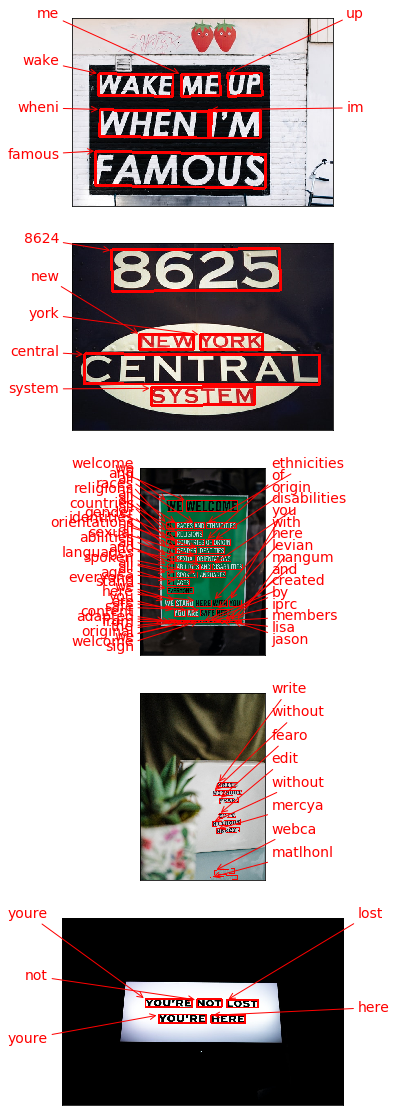

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract OCR 사용하는 함수

In [6]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/ssac12/aiffel/ocr_python/0000.png
/home/ssac12/aiffel/ocr_python/0001.png
/home/ssac12/aiffel/ocr_python/0002.png
/home/ssac12/aiffel/ocr_python/0003.png
/home/ssac12/aiffel/ocr_python/0004.png
/home/ssac12/aiffel/ocr_python/0005.png
/home/ssac12/aiffel/ocr_python/0006.png
/home/ssac12/aiffel/ocr_python/0007.png
/home/ssac12/aiffel/ocr_python/0008.png
/home/ssac12/aiffel/ocr_python/0009.png
/home/ssac12/aiffel/ocr_python/0010.png
/home/ssac12/aiffel/ocr_python/0011.png
/home/ssac12/aiffel/ocr_python/0012.png
/home/ssac12/aiffel/ocr_python/0013.png
/home/ssac12/aiffel/ocr_python/0014.png
/home/ssac12/aiffel/ocr_python/0015.png


In [7]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Ntro.



| 1%)

Ming

/ das

'EDeres

NUtrition nels

ro. alg

CSten.

laltbar

Dis:

“ONSOmp

Ure

rOrii

Done


## Step 1. 검증용 데이터셋 준비

In [8]:
testpath = os.getenv('HOME')+'/aiffel/ocr_python/test_files/'
file_list = os.listdir(testpath)

In [9]:
img_name = []
for i in file_list:
    img_name.append(testpath + i) 

print(img_name)

['/home/ssac12/aiffel/ocr_python/test_files/4.jpg', '/home/ssac12/aiffel/ocr_python/test_files/8.jpg', '/home/ssac12/aiffel/ocr_python/test_files/10.jpg', '/home/ssac12/aiffel/ocr_python/test_files/9.jpg', '/home/ssac12/aiffel/ocr_python/test_files/2.jpg', '/home/ssac12/aiffel/ocr_python/test_files/7.jpg', '/home/ssac12/aiffel/ocr_python/test_files/6.jpg', '/home/ssac12/aiffel/ocr_python/test_files/3.jpg', '/home/ssac12/aiffel/ocr_python/test_files/5.jpg', '/home/ssac12/aiffel/ocr_python/test_files/1.jpg']


## Step 2. Google OCR API, Keras-ocr, Tesseract로 테스트

### 1. Google OCR API

In [10]:
for i in img_name:
    detect_text(i)

Texts:

"30
Failte Gu
Welcome to
TAIRBEART
TARBERT
Please drive carefully
"

"30"

"Failte"

"Gu"

"Welcome"

"to"

"TAIRBEART"

"TARBERT"

"Please"

"drive"

"carefully"
bounds: (107,188),(154,189),(154,200),(107,199)
Texts:

"Glaschu
Glasgow
A 83 (A 82)
alamy
a
alamy
alam
al
a
ja
a
alamy
a alamy stock photo
BP1CGB
www.alamy.com
"

"Glaschu"

"Glasgow"

"A"

"83"

"(A"

"82)"

"alamy"

"a"

"alamy"

"alam"

"al"

"a"

"ja"

"a"

"alamy"

"a"

"alamy"

"stock"

"photo"

"BP1CGB"

"www.alamy.com"
bounds: (1122,920),(1243,920),(1243,936),(1122,936)
Texts:

"ONE WAY
"

"ONE"

"WAY"
bounds: (143,111),(210,111),(210,151),(143,151)
Texts:

"GOLF COURSE
GRAY ST
79
46 km
Geraldine
Christchurch 186 km
50
什个
"

"GOLF"

"COURSE"

"GRAY"

"ST"

"79"

"46"

"km"

"Geraldine"

"Christchurch"

"186"

"km"

"50"

"什"

"个"
bounds: (851,143),(850,228),(753,227),(754,142)
Texts:

"GOLF COURSE
GRAY ST
79
46 km
Geraldine
Christchurch 186 km
50
什个
"

"GOLF"

"COURSE"

"GRAY"

"ST"

"79"

"46"

"km"

"Gerald

### 2. Keras-ocr

In [11]:
image_urls = img_name
images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

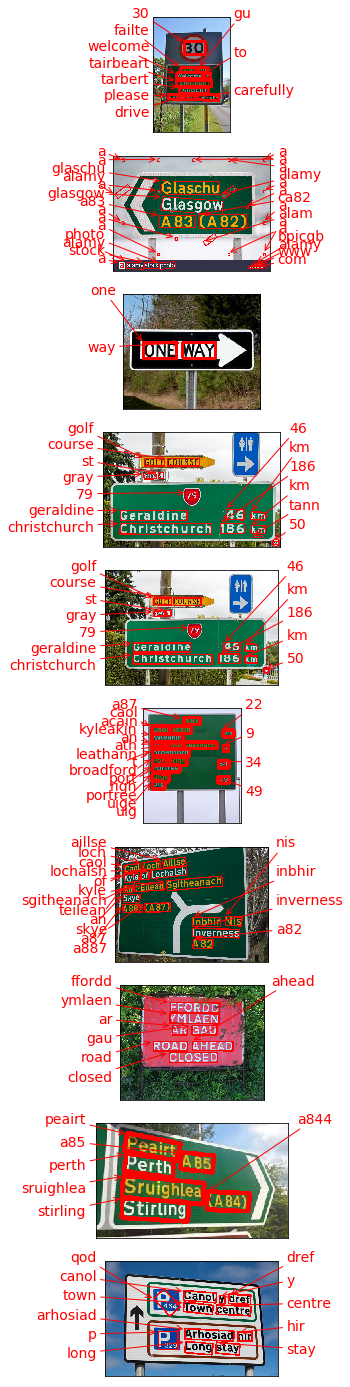

In [12]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(25, 25))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract OCR

In [13]:
recognize_images(img_name)



| = ee ED |

_ |


a



ES )


Done


## Step 3. 테스트 결과 정리 및 결과 분석,  결론 제시

구현하고자 했던 서비스는 도로에서의 도로표지판을 읽는 서비스로, 주행자가 도로표지판을 놓치고 지나쳐도, 따로 읽을 수 있도록 해준다.</br>

OCR 모델이 부합하는지 확인하기 위한 평가기준으로는 다음과 같이 있다.
1. 정확성
2. 신속성

</br>
위 기준에 따라 테스트 결과를 분석하면 다음과 같다.</br>

정확성 : Keras, Goggle OCR API > Tesseract </br> 

신속성 : Tesseract > Goggle OCR API > Keras </br>

위 평가기준에 의하면 Google OCR API가 합리적인 선택이라고 볼 수 있다.  
